# Deep learning model for a robotic autonomous car
This is the main notebook of the project.
The model is inspired by the architecture proposed in this paper from Nvidia: https://arxiv.org/pdf/1604.07316.pdf

## Libraries

In [1]:
# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from concurrent.futures import ThreadPoolExecutor

# image handling
from imgaug import augmenters as iaa
from PIL import Image
import cv2

# machine learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Dense
from sklearn.model_selection import train_test_split

print( f'tf.version: {tf.__version__}')

tf.version: 2.15.0


## Data preparation

### Image loading

In [3]:
data_dir = '/content/drive/My Drive/Mi educación/TFGs/TFG inf/driving-frames'
model_output_dir = '/content/drive/My Drive/Mi educación/TFGs/TFG inf/trained-models'

In [4]:
# Dataset creation
# --------
# The training set is composed by frames of the driving videos obatined by the
# car camera. Each frame is an image whose name contains the steering angle in
# which the car had to drive to follow the lane lines and keep itslef in the
# circuit. Those angles where computed while driving the car manually with the
# method manual_driver of SmartPiCar. The obtained images and its angles where
# manually cleaned and corrected to account for some bad entries.
#
# The validation set is composed by frames of different driving videos,
# including different circuits. This improved the performance of the model
# significantly.
#
# For the labels, they come from the names of the images.
#   - 90º: keep going straight
#   - <90º: turn left
#   - >90º: turn right

def get_image_paths(directory, extension='png'):
  """Return an ordered list of all .png files in a given directory."""
  file_names = os.listdir(directory)
  file_names = sorted(file_names)
  img_paths = [os.path.join(directory,name) for name in file_names if name[-4:]
               == f'.{extension}']

  return img_paths

train_img_paths = get_image_paths(os.path.join(data_dir,'training'))
val_img_paths = get_image_paths(os.path.join(data_dir,'validation'))

train_angles = [int(name[-7:-4]) for name in train_img_paths]
val_angles = [int(name[-7:-4]) for name in val_img_paths]

### Data verification

Number of images for training: 8695
Number of steering angles: 8695


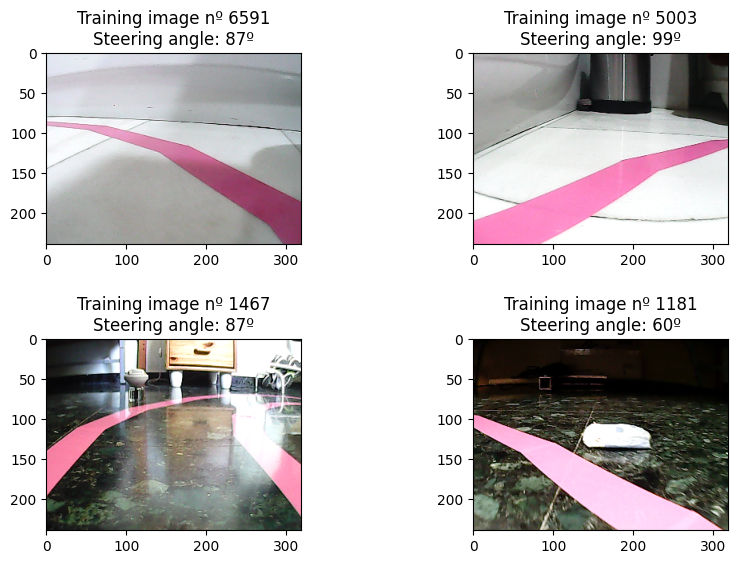

In [5]:
# Training set

# Check that the number of features and labels is the same
print(f'Number of images for training: {len(train_img_paths)}')
print(f'Number of steering angles: {len(train_angles)}')

# Visualize four images and check that its steering angle is correct
nrow, ncol = 2, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(9, 6))

for ax in axes.flatten():
  index = np.random.randint(0, len(train_img_paths) - 1)
  ax.imshow(Image.open(train_img_paths[index]))
  ax.set_title((f'Training image nº {index}\n'
                f'Steering angle: {train_angles[index]}º'))

fig.tight_layout(pad=2.0)
plt.show()

Number of images for validation: 786
Number of steering angles: 786


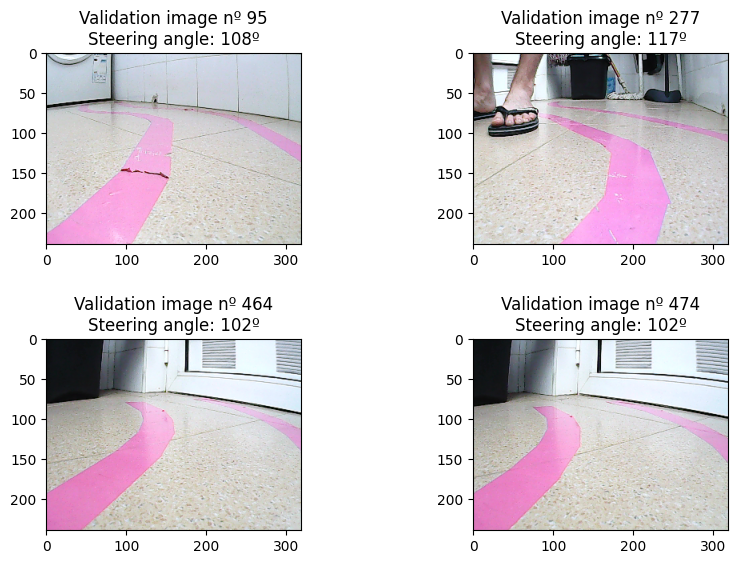

In [6]:
# Validation set

# Check that the number of features and labels is the same
print(f'Number of images for validation: {len(val_img_paths)}')
print(f'Number of steering angles: {len(val_angles)}')

# Visualize four images and check that its steering angle is correct
nrow, ncol = 2, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(9, 6))

for ax in axes.flatten():
  index = np.random.randint(0, len(val_img_paths) - 1)
  ax.imshow(Image.open(val_img_paths[index]))
  ax.set_title((f'Validation image nº {index}\n'
                f'Steering angle: {val_angles[index]}º'))

fig.tight_layout(pad=2.0)
plt.show()

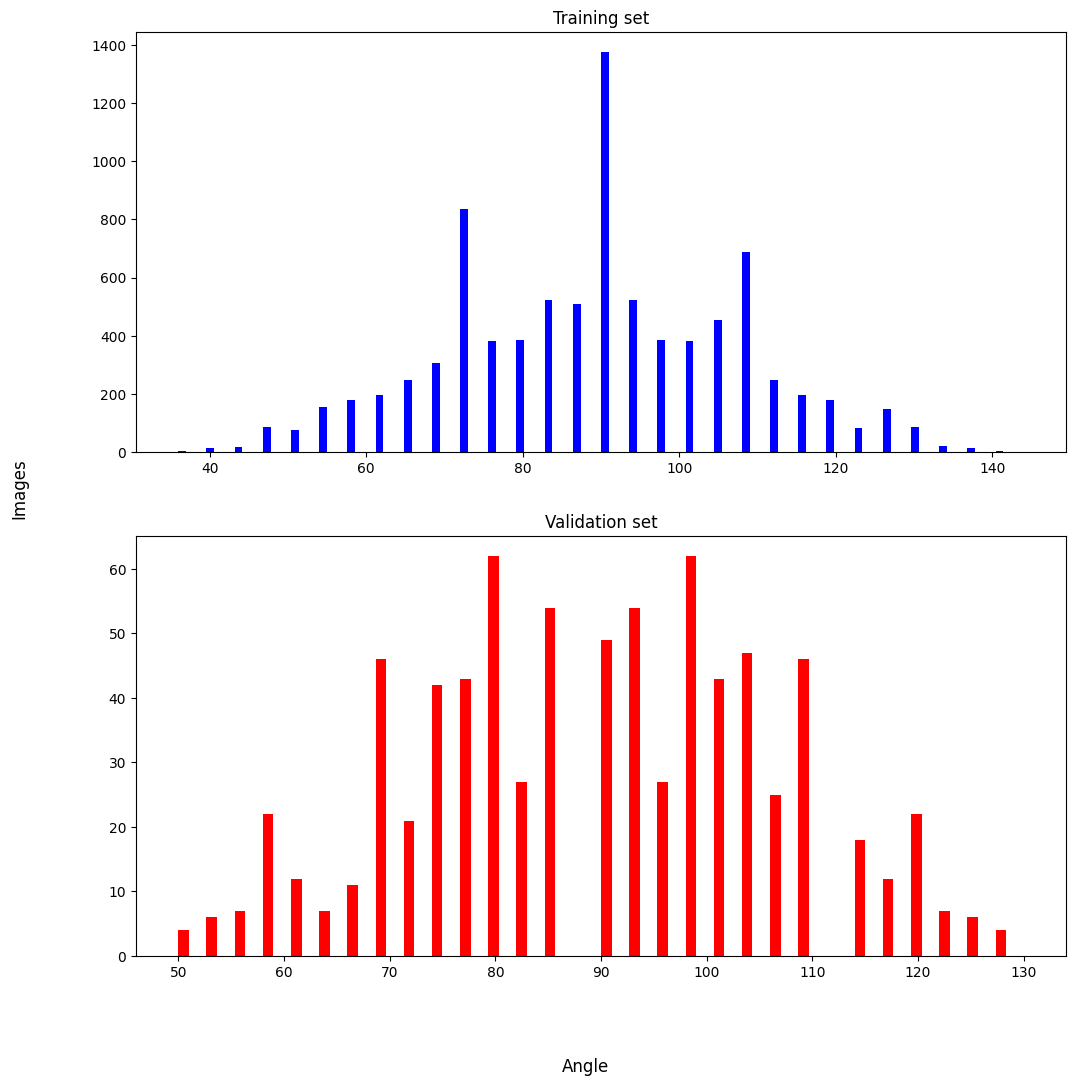

In [7]:
# Check steering angle distribution for both sets
fig, axes = plt.subplots(2,1, figsize=(12, 12))
axes[0].hist(train_angles, bins=30, width=1, color='blue')
axes[0].set_title('Training set')

axes[1].hist(val_angles, bins=30, width=1, color='red')
axes[1].set_title('Validation set')

fig.supxlabel('Angle')
fig.supylabel('Images')
plt.show()

### Volteado de las imágenes

In [8]:
imgs_have_been_flipped = True

def flip_driving_frames(frame_paths, frame_angles, output_dir=False):
  """Flip a list of images horizontally and one of angles with respect to 90º.

  The new images are stored with the new angle in their name at the same
  directory.
  """
  img_dir = frame_paths[0][:-23]

  if not output_dir:
    output_dir = img_dir

  for i in range(len(frame_paths)):

    img = cv2.imread(frame_paths[i])
    img = cv2.flip(img,1)

    # inversión del ángulo
    img_angle = 180 - frame_angles[i]
    img_angle = str(img_angle)
    zero_angle = img_angle.zfill(3)

    # se cambia el nombre con la nueva dirección
    img_name = f'{frame_paths[i][-21:-9]}i-a{zero_angle}.png'
    img_path = os.path.join(output_dir,img_name)

    cv2.imwrite(img_path, img)

  imgs_have_been_flipped = True

# Flipped images are saved in memory, so the method has to execute
# only once.
if not imgs_have_been_flipped:
  flip_driving_frames(train_img_paths, train_angles)
  flip_driving_frames(val_img_paths, val_angles)

### Batch generator (discarded)

In [9]:
def flip_images(img_paths, steering_angles):
  """Flip the images horizontally and flip the angles around 90º."""

  aug_images = []
  new_st_angles = []

  for i in range(len(img_paths)):

    image = cv2.imread(img_paths[i])
    aug_images.append(image)
    new_st_angles.append(steering_angles[i])

    aug_images.append(cv2.flip(image,1))
    new_st_angles.append(180 - steering_angles[i])

  random.Random(870652).shuffle(aug_images)
  random.Random(870652).shuffle(new_st_angles)

  return aug_images, new_st_angles

def flip(image, steering_angle):
  flipped_image = cv2.flip(image,1)
  steering_angle = 180 - steering_angle

  return flipped_image, steering_angle

def blur(image):
  ksize = np.random.randint(1,5)
  blurred_image = cv2.blur(image, (ksize,ksize))

  return blurred_image

def change_brightness(image):
  brightness = iaa.Multiply((0.5, 1.2))
  image = brightness.augment_image(image)

  return image


def img_augment(image, steering_angle):
  """Augments a random image"""
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = blur(image)
  if np.random.rand() < 0.5:
    image = change_brightness(image)

  return image, steering_angle

In [10]:
def batch_generator(image_paths, steering_angles, batch_size):

  batch_images = []
  batch_steering_angles = []
  seed = 123

  for i in range(batch_size):
    index = random.Random(i+seed).randint(0, len(image_paths) - 1)
    img = cv2.imread(image_paths[index])

    img_paths, steering_angle = img_augment(img, steering_angles[index])

    img = img_preprocess(img)

    batch_images.append(img)
    batch_steering_angles.append(steering_angle)

  yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

"""
#test
nrows = 2
ncols = 2

X_train_batch, y_train_batch = next(batch_generator(X_train, y_train, nrows))
X_valid_batch, y_valid_batch = next(batch_generator(X_val, y_val, nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
#fig.tight_layout()

for i in range(nrows):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])
"""

'\n#test\nnrows = 2\nncols = 2\n\nX_train_batch, y_train_batch = next(batch_generator(X_train, y_train, nrows))\nX_valid_batch, y_valid_batch = next(batch_generator(X_val, y_val, nrows))\n\nfig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))\n#fig.tight_layout()\n\nfor i in range(nrows):\n    axes[i][0].imshow(X_train_batch[i])\n    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])\n    axes[i][1].imshow(X_valid_batch[i])\n    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])\n'

In [11]:
class data_generator(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.Random(123).shuffle(self.x)
            np.random.Random(123).shuffle(self.y)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        images = []

        for i in range(len(batch_x)):
          img = cv2.imread(batch_x[i])

          img, batch_y[i] = img_augment(img, batch_y[i])
          img = img_preprocess(img)

          images.append(img)

        return np.array(images), np.array(batch_y)

## Deep learning model

In [12]:
"""
The model takes as an input an image of size 200x66 and returns a number.

The input size is due to the fact that the car only needs the lower half of
the image to guess the best steering angle.

The output number is the estimated steering angle for that image.
"""
model = tf.keras.Sequential([

  # augmenting layers, discarded because they didn't improve performance
  # model.add(keras.layers.RandomContrast(0.1))
  # model.add(keras.layers.RandomBrightness(0.1, value_range=(0, 1)))

  # convolutional layers
  Conv2D(24, 5, strides=(2, 2), input_shape=(66, 200, 3),
                         activation='elu'),
  Conv2D(36, 5, strides=(2, 2), activation='elu'),
  Conv2D(48, 5, strides=(2, 2), activation='elu'),
  Conv2D(64, 3, activation='elu'),
  Conv2D(64, 3, activation='elu'),

  # fully connected layers
  keras.layers.Flatten(),

  Dense(100, activation='elu'),
  Dense(50, activation='elu'),
  keras.layers.Dense(10, activation='elu'),

  # output layer
  Dense(1)
])

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt, metrics='MeanAbsoluteError')

model.build((32,66,200,3))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

## Image preprocessing for the model

In [14]:
def img_preprocess(image_path):

  img = cv2.imread(image_path)

  # discard the upper part of the image
  height = len(img)
  img = img[int(height/2):,:,:]

  img = cv2.resize(img, (200,66))

  # change the color system. It was seen to improve performance
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = img / 255

  return img

In [15]:
def parallel_img_preprocess(image_paths):
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(img_preprocess, image_paths))
    return np.asarray(images)

In [16]:
# apply preprocessing function to the datasets & convert to numpy
# X_train = np.asarray([img_preprocess(i) for i in train_img_paths])
# X_val = np.asarray([img_preprocess(i) for i in val_img_paths])

X_train = parallel_img_preprocess(train_img_paths)
X_val = parallel_img_preprocess(val_img_paths)

Y_train = np.asarray(train_angles)
Y_val = np.asarray(val_angles)

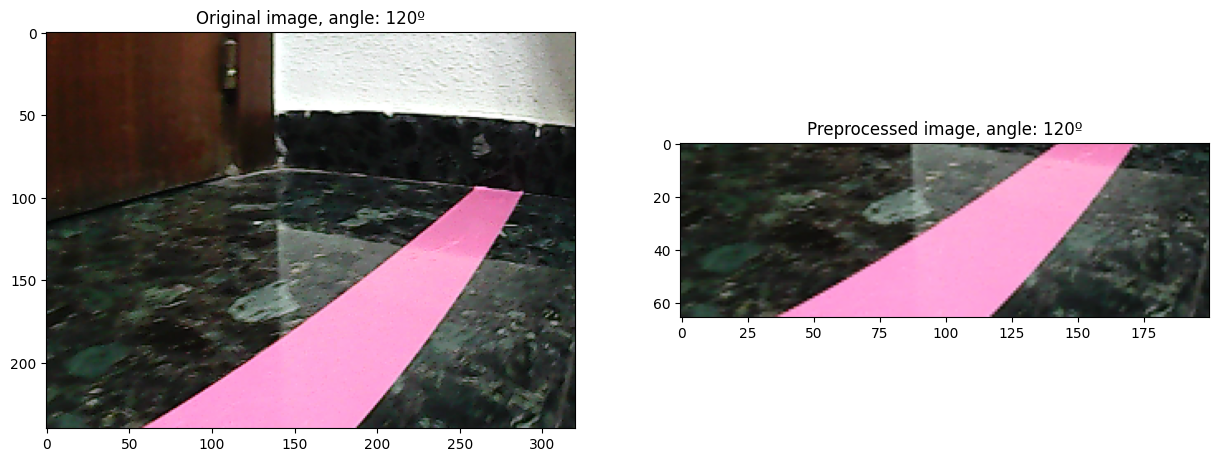

In [17]:
# Check a sample of the dataset
index = np.random.randint(0, len(val_angles) - 1)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(Image.open(train_img_paths[index]))
axes[0].set_title(f'Original image, angle: {train_angles[index]}º')
axes[1].imshow(X_train[index])
axes[1].set_title(f'Preprocessed image, angle: {Y_train[index]}º')
plt.show()

The shape of the training dataset is: (8695, 66, 200, 3) & it has 8695 labels.
The shape of the training dataset is: (786, 66, 200, 3) & it has 786 labels.



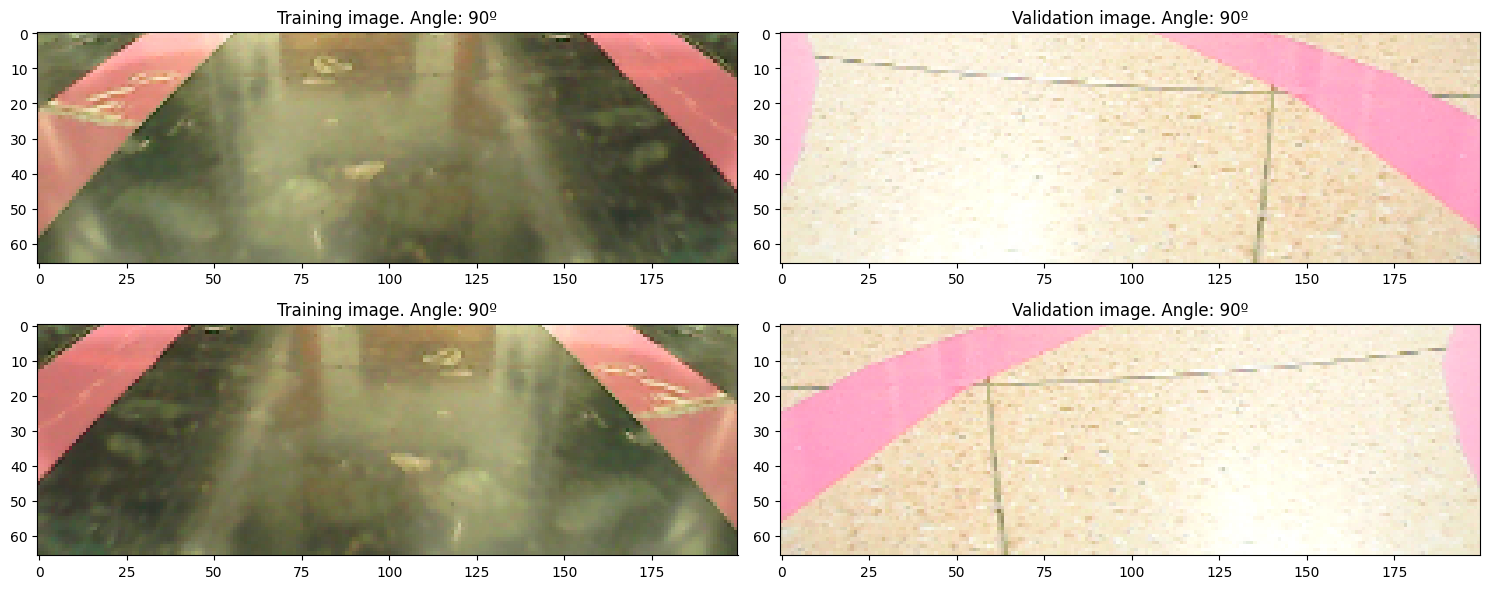

In [18]:
print(f'The shape of the training dataset is: {X_train.shape} '
      f'& it has {len(Y_train)} labels.')
print(f'The shape of the training dataset is: {X_val.shape} '
      f'& it has {len(Y_val)} labels.\n')

# Visualize four images and check that its steering angle is correct
nrow, ncol = 2, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))

for i in range(nrow):
    axes[i][0].imshow(X_train[i])
    axes[i][0].set_title(f'Training image. Angle: {Y_train[i]}º')
    axes[i][1].imshow(X_val[i])
    axes[i][1].set_title(f'Validation image. Angle: {Y_val[i]}º')

fig.tight_layout()
plt.show()

In [19]:
# clear some variables to free up memory
del(train_img_paths)
del(val_img_paths)

## Training and results

In [20]:
history = None
model_name = 'lane-nav'

In [21]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir, f'{model_name}-checkpoint.keras'),
                          verbose=1, save_best_only=True)

history = model.fit(X_train, Y_train, batch_size=32,
                              epochs=10,
                              validation_data = (X_val, Y_val),
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

Epoch 1/10
272/272 [==============================] - ETA: 0s - loss: 501.4619 - mean_absolute_error: 16.7829
Epoch 1: val_loss improved from inf to 281.07361, saving model to /content/drive/My Drive/Mi educación/TFGs/TFG inf/trained-models/lane-nav-checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


272/272 [==============================] - 64s 228ms/step - loss: 501.4619 - mean_absolute_error: 16.7829 - val_loss: 281.0736 - val_mean_absolute_error: 13.9769
Epoch 2/10
272/272 [==============================] - ETA: 0s - loss: 245.7379 - mean_absolute_error: 11.3844
Epoch 2: val_loss improved from 281.07361 to 142.04370, saving model to /content/drive/My Drive/Mi educación/TFGs/TFG inf/trained-models/lane-nav-checkpoint.h5
272/272 [==============================] - 61s 226ms/step - loss: 245.7379 - mean_absolute_error: 11.3844 - val_loss: 142.0437 - val_mean_absolute_error: 8.7220
Epoch 3/10
272/272 [==============================] - ETA: 0s - loss: 86.1522 - mean_absolute_error: 6.3257
Epoch 3: val_loss improved from 142.04370 to 68.02888, saving model to /content/drive/My Drive/Mi educación/TFGs/TFG inf/trained-models/lane-nav-checkpoint.h5
272/272 [==============================] - 61s 224ms/step - loss: 86.1522 - mean_absolute_error: 6.3257 - val_loss: 68.0289 - val_mean_absol

KeyboardInterrupt: 

In [ ]:
# save the model with its mean absolute error on the validation set
mean_absolute_error = round(model.metrics[1].result().numpy(),2)
filename = f'{model_name}-{mean_absolute_error:.2f}.keras'
model.save(os.path.join(model_output_dir, filename), save_format='keras')

In [ ]:
# plot learning curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')

plt.legend(loc='upper right')
plt.ylabel('Mean cuadratic error')
plt.title('Training nº 48')
plt.xlabel('epoch', labelpad=2)

ax.yaxis.tick_right()
plt.show()

## Model re-training

In [ ]:
# After training the model, more data was collected. That motivated the
# creation of these lines of code to continue training the model with this
# data.

# clear some variables to free up memory
del(model)

# load a trained model
model_name = 'lane-nav'
trained_model = keras.models.load_model(os.path.join(model_output_dir,
                                                     f'{model_name}.keras'))

In [ ]:
# load more images
ft_img_paths = get_image_paths(os.path.join(data_dir,'fine-tuning'))
ft_angles = [int(name[-7:-4]) for name in ft_img_paths]

# Images have already been flipped
# flip_driving_frames(ft_img_paths, ft_angles)

X_train_ft = np.asarray([img_preprocess(i) for i in ft_img_paths])
Y_train_ft = np.asarray(ft_angles)
X_train = np.concatenate((X_train, X_train_ft))
Y_train = np.concatenate((Y_train, Y_train_ft))

print(X_train.shape)
print(Y_train.shape)

In [ ]:
# new compilation and training
trained_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=0.00003)) # lower learning rate

new_name = f'{model_name}-ft2'

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir, f'{new_name}-checkpoint.keras'),
    verbose=1, save_best_only=True)

history_ft = trained_model.fit(X_train, Y_train, batch_size=32,
                              epochs=5,
                              validation_data = (X_val, Y_val),
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

In [ ]:
# save the model with its mean absolute error on the validation set
mean_absolute_error = round(model.metrics[1].result().numpy(),2)
filename = f'{new_name}-{mean_absolute_error:.2f}.keras'
model.save(os.path.join(model_output_dir, filename), save_format='keras')

In [ ]:
# plot learning curves
train_loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8,8))

plt.plot(range(2, len(train_loss) + 2), train_loss, label='Training loss')
plt.plot(range(2, len(train_loss) + 2), val_loss, label='Validation loss')

plt.legend(loc='upper right')
plt.ylabel('Mean cuadratic error')
plt.title('Training nº 48')
plt.xlabel('epoch', labelpad=2)

plt.show()